In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/lankenau/isotools/src')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

path = '/path/to/data'
alignment_path = 'alignment_v45'
genome_file = 'GRCh38.p14.genome.fa'
genome_path = os.path.join(path, 'gencode_human/version_45', genome_file)

In [4]:
metadata_file = 'reads/metadata_tissue.tsv'
metadata = pd.read_csv(os.path.join(path, metadata_file), sep='\t')
tissues = metadata['group'].unique()
tissues

array(['aorta', 'brain', 'colon', 'heart', 'lung', 'muscle', 'ovary',
       'vessel'], dtype=object)

In [5]:
import logging
from isotools import Transcriptome
from isotools.plots import plot_bar
from isotools import __version__ as isotools_version
# set up logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')
logger.info(f'This is isotools version {isotools_version}')

INFO:This is isotools version 0.3.5rc10


In [6]:
isoseq: Transcriptome = Transcriptome.load("results/isoseq_v45.pkl")

INFO:loading transcriptome from results/isoseq_v45.pkl


In [39]:
group_idx = {gn:[i for i,sa in enumerate(isoseq.samples) if sa in grp] for gn,grp in isoseq.groups().items()}

In [40]:
for tissue in tissues:
    filter_name = 'IN' + tissue.upper()
    tissue_index = group_idx[tissue]
    # TODO: Lower coverage threshold, high for now to reduce time
    expression = f'g.coverage[{tissue_index},transcript_id].sum() >= 10'
    isoseq.add_filter(tag=filter_name, expression=expression, context='transcript')
    print(f'Added filter {filter_name} for tissue {tissue}: {expression}')

Added filter INAORTA for tissue aorta: g.coverage[[0, 1],transcript_id].sum() >= 10
Added filter INBRAIN for tissue brain: g.coverage[[2, 3, 4, 5],transcript_id].sum() >= 10
Added filter INCOLON for tissue colon: g.coverage[[6, 7],transcript_id].sum() >= 10
Added filter INHEART for tissue heart: g.coverage[[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],transcript_id].sum() >= 10
Added filter INLUNG for tissue lung: g.coverage[[24, 25, 26, 27],transcript_id].sum() >= 10
Added filter INMUSCLE for tissue muscle: g.coverage[[28, 29],transcript_id].sum() >= 10
Added filter INOVARY for tissue ovary: g.coverage[[30, 31],transcript_id].sum() >= 10
Added filter INVESSEL for tissue vessel: g.coverage[[32, 33],transcript_id].sum() >= 10


In [41]:
isoseq.add_filter(tag='HIGH_COVER',
                  expression='g.coverage.sum(0)[transcript_id] >= 7',
                  context='transcript')
isoseq.add_filter(tag='PERMISSIVE', expression='FSM or not (RTTS or INTERNAL_PRIMING or FRAGMENT)', context='transcript')
isoseq.add_filter(tag='BALANCED', expression='FSM or (HIGH_COVER and not (RTTS or FRAGMENT or INTERNAL_PRIMING))', context='transcript')
isoseq.add_filter(tag='STRICT', expression='SUBSTANTIAL and (FSM or not (RTTS or FRAGMENT or INTERNAL_PRIMING))', context='transcript')

In [43]:
# define the filtering shemes
permissive='(FSM or not (RTTS or INTERNAL_PRIMING or FRAGMENT))'

balanced='(FSM or (HIGH_COVER and not (RTTS or FRAGMENT or INTERNAL_PRIMING)))'

strict='(SUBSTANTIAL and (FSM or not (RTTS or FRAGMENT or INTERNAL_PRIMING)))'

In [ ]:
for tissue in tissues:
    isoseq.write_gtf(f'results/isotools_{tissue}.gtf', min_coverage=0, gzip=False, query='IN' + tissue.upper() + ' and BALANCED')

INFO:writing gtf file to results/isotools_aorta.gtf
INFO:writing gtf file to results/isotools_brain.gtf
INFO:writing gtf file to results/isotools_colon.gtf
INFO:writing gtf file to results/isotools_heart.gtf
INFO:writing gtf file to results/isotools_lung.gtf
INFO:writing gtf file to results/isotools_muscle.gtf
INFO:writing gtf file to results/isotools_ovary.gtf
INFO:writing gtf file to results/isotools_vessel.gtf


In [ ]:
%%script false --no-raise-error
plt.rcParams["figure.figsize"] = (6,6)
fig, axs=plt.subplots(1,2)

plot_saturation(isoseq,cov_th=5, expr_th=[100, 200, 400, 1000, 5000],
                x_range=(1e2,1.3e5,1e2), ax=axs[0])

rarefraction, total=isoseq.rarefaction(min_coverage=2, tr_filter={'query':'FSM'})
plot_rarefaction(rarefraction, total=total, ax=axs[1])

fig.tight_layout()

In [ ]:
f_stats_groups=isoseq.filter_stats(
    tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
    groups=isoseq.groups(),
    weight_by_coverage=True,
    min_coverage=2)

f_stats_samples=isoseq.filter_stats(
    tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
    weight_by_coverage=True,
    min_coverage=2)

<Axes: title={'center': 'Expressed Transcripts > 2 reads'}, ylabel='fraction of reads'>

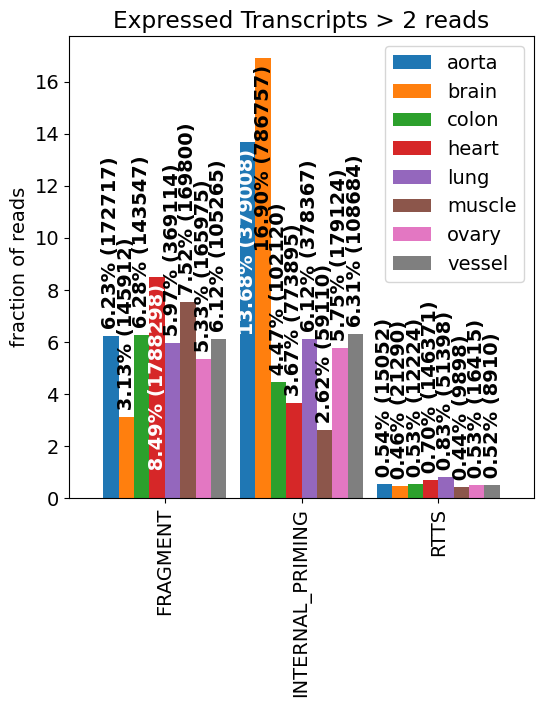

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,1)

group_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# groupwise statistics
plot_bar(f_stats_groups[0], ax=axs, drop_categories=['PASS'], bar_width=.9,
         legend=True, colors=group_colors, **f_stats_groups[1])

In [ ]:
# compute the alternative splicng events
splice_events=isoseq.alternative_splicing_events(progress_bar=True)
# count the identified events by type
splice_events.splice_type.value_counts()

  0%|          | 0/541983 [00:00<?, ?genes/s]

100%|██████████| 541983/541983 [21:21<00:00, 422.98genes/s]


splice_type
TSS    21723
PAS    14451
IR     10218
ES      6730
5AS     4519
3AS     4461
ME      1465
Name: count, dtype: int64

In [ ]:
splice_events

,gene,chr,start,end,splice_type,novel,ENCSR700EBI_in_cov,ENCSR425HFS_in_cov,ENCSR463IDK_in_cov,ENCSR205QMF_in_cov,...,ENCSR261GOA_total_cov,ENCSR096QUP_total_cov,ENCSR986WKB_total_cov,ENCSR323XND_total_cov,ENCSR803QWH_total_cov,ENCSR243DYK_total_cov,ENCSR477HHG_total_cov,ENCSR507WZC_total_cov,ENCSR853YZN_total_cov,ENCSR138TAS_total_cov
0,ENSG00000277400.1,GL000194.1,53892,54677,IR,True,2,1,0,0,...,7,13,3,9,2,2,17,5,0,7
1,ENSG00000277400.1,GL000194.1,61662,62949,PAS,True,6,20,2,1,...,57,30,15,29,12,6,78,13,3,46
2,ENSG00000277400.1,GL000194.1,66335,69128,PAS,True,12,55,4,13,...,57,30,15,29,12,6,78,13,3,46
3,ENSG00000277400.1,GL000194.1,114985,115065,TSS,True,5,3,0,1,...,62,33,16,36,15,7,81,13,3,49
4,ENSG00000274847.1,GL000194.1,53862,54677,3AS,True,1,1,0,2,...,5,11,5,13,2,0,13,6,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63562,PB_novel_145329,KI270742.1,107775,109791,5AS,True,1,0,3,2,...,13,0,1,2,7,3,17,3,0,5
63563,PB_novel_145329,KI270742.1,4256,4513,PAS,True,4,1,0,2,...,14,1,1,4,7,4,18,3,0,6
63564,PB_novel_145329,KI270742.1,23837,24339,PAS,True,4,1,5,2,...,14,1,1,4,7,4,18,3,0,6
63565,PB_novel_145329,KI270742.1,109191,109961,TSS,True,1,0,3,2,...,14,1,1,4,7,4,18,3,0,6
